In [18]:
import cv2
import os
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as dataset
import torch.utils.data as data
import torch.nn.functional as F
from matplotlib import pyplot as plt
import numpy as np

In [17]:
for i in range(24):
    listdir= 'written_origin/{}'.format(i)
    savedir='written_name/{}'.format(i)
    for lis in os.listdir(listdir):
        pic=cv2.imread(os.path.join(listdir,lis))
        pic=cv2.cvtColor(pic,cv2.COLOR_BGR2GRAY)
        _,pic=cv2.threshold(pic, 0.65*pic.mean()+0.5*pic.min(), 255, cv2.THRESH_BINARY)
        cv2.imwrite(savedir+'/'+lis,pic)

In [19]:
class ResidualBlock(torch.nn.Module):
    def __init__(self,channels):
        super(ResidualBlock,self).__init__()
        self.channels = channels
        
        self.conv1 = nn.Conv2d(channels,channels,kernel_size=3,padding=1)
        self.conv2 = nn.Conv2d(channels,channels,kernel_size=3,padding=1)
    
    def forward(self, x):
        y = F.relu(self.conv1(x))
        y = self.conv2(y)
        return F.relu(x+y)


In [20]:
class Network(nn.Module):
    def __init__(self,num_class=10):
        super().__init__()
        self.layer1=nn.Sequential(nn.Conv2d(3,32,kernel_size=7,padding=1),#m*16*224*224
                                  nn.BatchNorm2d(32),
                                  nn.ReLU(),
                                  nn.MaxPool2d(2),#m*32*112*112
                                  ResidualBlock(32),
                                  ResidualBlock(32)
                                  )
        self.layer2=nn.Sequential(nn.Conv2d(32,64,kernel_size=3,padding=1),#m*64*112*112
                                  nn.BatchNorm2d(64),
                                  nn.ReLU(),
                                  nn.MaxPool2d(2),#m*64*56*56
                                  ResidualBlock(64),
                                  ResidualBlock(64)
                                  )
        self.layer3=nn.Sequential(nn.Conv2d(64,128,kernel_size=3,padding=1),#m*128*56*56
                                  nn.BatchNorm2d(128),
                                  nn.ReLU(),
                                  nn.MaxPool2d(2),#m*128*28*28
                                  ResidualBlock(128),
                                  ResidualBlock(128)
                                  )
        self.layer4=nn.Sequential(nn.Conv2d(128,256,kernel_size=3,padding=1),#m*128*28*28
                                  nn.BatchNorm2d(256),
                                  nn.ReLU(),
                                  nn.MaxPool2d(2),#m*128*14*14
                                  ResidualBlock(256),
                                  ResidualBlock(256)
                                  )
        self.layer5=nn.Sequential(nn.Conv2d(256,512,kernel_size=3,padding=1),#m*512*14*14
                                  nn.BatchNorm2d(512),
                                  nn.ReLU(),
                                  nn.MaxPool2d(2),#m*512*7*7
                                  ResidualBlock(512),
                                  ResidualBlock(512)
                                  )
        self.fc = nn.Linear(512*7*7,num_class)
        
    def forward(self,x):
        # Flatten data from (n,1,28,28) to (n,784)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = x.reshape(x.size(0),-1)  # flatten
#         print(x.size(1))
        return self.fc(x)

In [36]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

transform = transforms.Compose(
    [transforms.Resize((228,228)),
     transforms.ToTensor(),
     transforms.Normalize(0.5,0.5),
    ]
)

batch_size = 5

train_set = dataset.ImageFolder('written_name',transform=transform)
train_set,test_set = data.random_split(
                        train_set,lengths=[int(0.7 * len(train_set)),
                        len(train_set) - int(0.7 * len(train_set))],
                        generator=torch.Generator().manual_seed(0))#dataset.ImageFolder('written_test',transform=transform)
train_loader = torch.utils.data.DataLoader(dataset=train_set,
                                           batch_size=batch_size,
                                           shuffle=True
                                                )
test_loader = torch.utils.data.DataLoader(dataset=test_set,
                                          batch_size=batch_size,
                                          shuffle=False
                                                )
print(train_set[0])

(tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]]), 12)


In [47]:
model = Network(24).to(device)

pre = 1
if pre:
    model.load_state_dict(torch.load('./checkpoint/writtenmodel.pt'))
loss1 = nn.CrossEntropyLoss()

total_loader=len(train_loader)
Loss=[]

train = 1
if train:
    for epo in range(10):
        if epo%2==1:
            optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)#,momentum=0.5
        else:
            optimizer = torch.optim.SGD(model.parameters(),lr=1e-3)#,momentum=0.5
        for i,(img,label) in enumerate(train_loader):
            #img = torch.Tensor(np.abs(np.fft.fft2(img)))
            img=img.to(device)
            label=label.to(device)
            outputs=model(img)
            loss=loss1(outputs,label)
            Loss.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (i+1)%20==0 :
                print("第{}轮，批次：{}/{},当前误差：{:.4f}".format(epo+1,i+1,total_loader,loss.item()))

第1轮，批次：20/87,当前误差：0.0282
第1轮，批次：40/87,当前误差：0.0022
第1轮，批次：60/87,当前误差：0.0000
第1轮，批次：80/87,当前误差：0.0000
第2轮，批次：20/87,当前误差：0.0000
第2轮，批次：40/87,当前误差：0.0006
第2轮，批次：60/87,当前误差：0.0000
第2轮，批次：80/87,当前误差：0.0002
第3轮，批次：20/87,当前误差：0.0000
第3轮，批次：40/87,当前误差：0.0031
第3轮，批次：60/87,当前误差：0.0093
第3轮，批次：80/87,当前误差：0.0000
第4轮，批次：20/87,当前误差：0.0007
第4轮，批次：40/87,当前误差：0.3509
第4轮，批次：60/87,当前误差：0.0151
第4轮，批次：80/87,当前误差：0.0000
第5轮，批次：20/87,当前误差：0.0000
第5轮，批次：40/87,当前误差：0.0001
第5轮，批次：60/87,当前误差：0.0000
第5轮，批次：80/87,当前误差：0.0000
第6轮，批次：20/87,当前误差：0.0000
第6轮，批次：40/87,当前误差：0.0000
第6轮，批次：60/87,当前误差：0.0000
第6轮，批次：80/87,当前误差：0.0001
第7轮，批次：20/87,当前误差：0.0000
第7轮，批次：40/87,当前误差：0.0000
第7轮，批次：60/87,当前误差：0.0861
第7轮，批次：80/87,当前误差：0.0000
第8轮，批次：20/87,当前误差：0.0000
第8轮，批次：40/87,当前误差：0.0000
第8轮，批次：60/87,当前误差：0.0000
第8轮，批次：80/87,当前误差：0.0292
第9轮，批次：20/87,当前误差：0.0002
第9轮，批次：40/87,当前误差：0.0000
第9轮，批次：60/87,当前误差：0.0000
第9轮，批次：80/87,当前误差：0.0031
第10轮，批次：20/87,当前误差：0.0000
第10轮，批次：40/87,当前误差：0.0000
第10轮，批次：60/87,当前误差：0.0000
第10轮，批次：80/87,当前误差：0.0

In [46]:
torch.save(model.state_dict(), './checkpoint/writtenmodel.pt')

In [48]:
# 模型测试
model.eval()#使用训练学到的均值和方差，禁止BN层继续学习mean和var 
with torch.no_grad(): #禁用梯度计算，节省时间，model.eval()已经可以保证正确
    correct = 0
    total = 0
    for images, labels in test_loader:
        #images = torch.Tensor(np.abs(np.fft.fft2(images)))
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1) #找出类别里最大的预测结果
        total += labels.size(0) #统计测试总数
        correct += (predicted == labels).sum().item() #统计预测正确总数
    
    print('模型在10000个测试图片的正确率为: {} %'.format(100 * correct / total))

模型在10000个测试图片的正确率为: 90.27027027027027 %


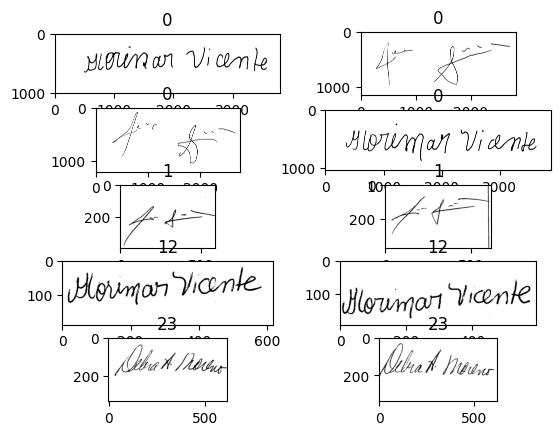

In [49]:
import os
from PIL import Image
test_dir = 'written_test'
with torch.no_grad():
    #数据加载
    i=0
    for pic in os.listdir(test_dir):
        image=Image.open(os.path.join(test_dir, pic)).convert("RGB")# #读入灰度图，WH两个维度 28*28*3
        image_t=transform(image).unsqueeze(0).cuda()
        #print(image_t.shape)
        outputs = model(image_t)
        #print(outputs)
        #print(outputs)
        _, predicted = torch.max(outputs.data, 1) # 输出模型中分值最高的
        plt.subplot(5,2,i+1)
        plt.imshow(image)
        plt.title(predicted.item())
        i+=1